In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", rc={"grid.color": "lightgray"})

In [ ]:
environments = [x for x in os.listdir('.') if os.path.isdir(x) if x != 'HalfCheetah']
results = {env: pd.read_csv(os.path.join(env, 'results.csv')) for env in environments}
lambdas = {env: [pd.read_csv(os.path.join(env, lmbaa)) for lmbaa in [x for x in sorted(os.listdir(env)) if x.startswith('lambda')]] for env in environments}
components = {env: [pd.read_csv(os.path.join(env, comp)) for comp in [x for x in sorted(os.listdir(env)) if x.startswith('component')]] for env in environments}


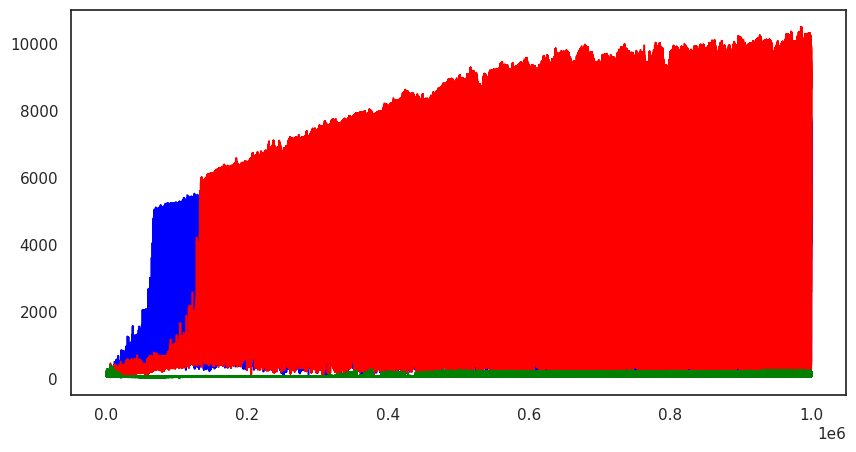

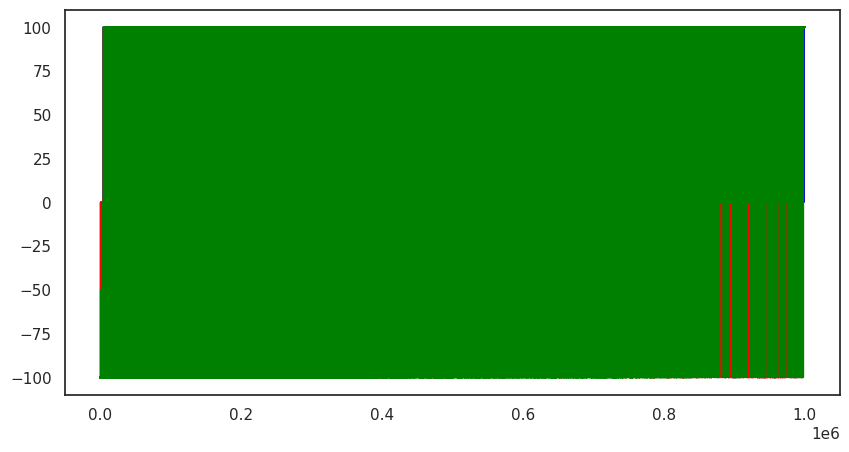

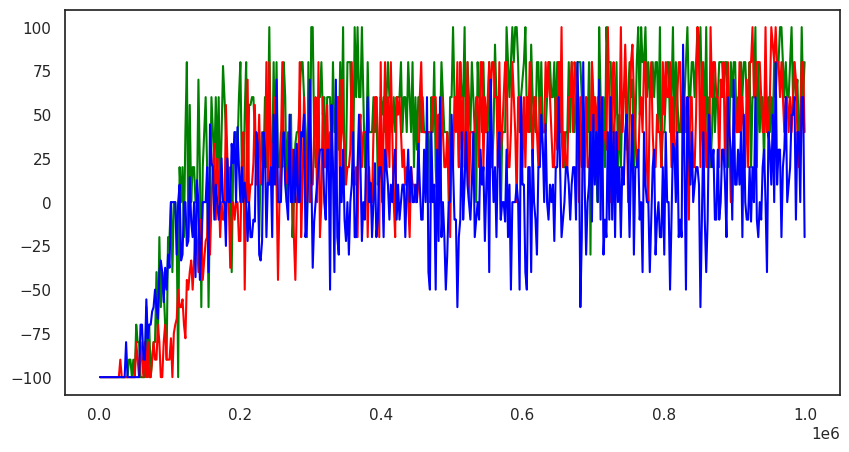

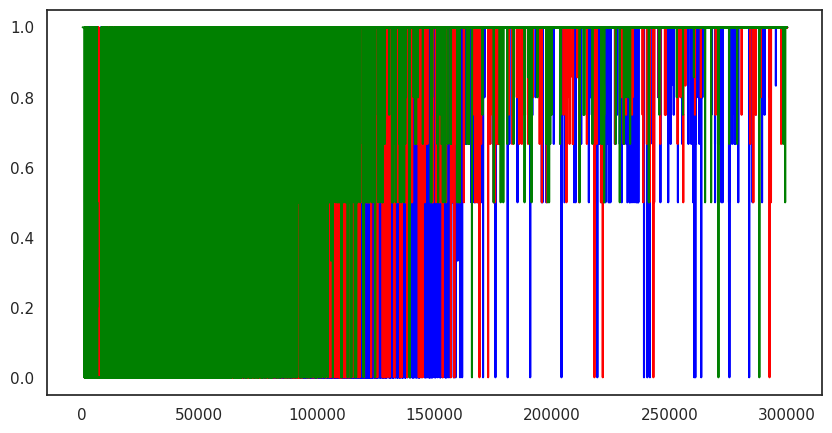

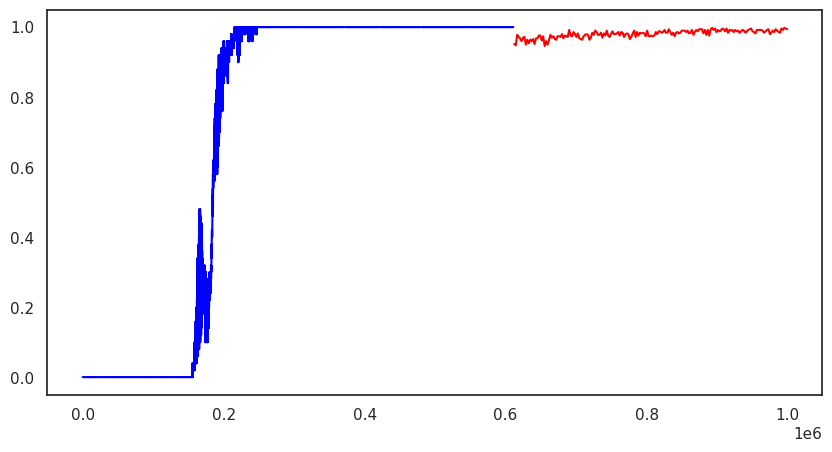

In [29]:
for env in environments:
    methods = list(
        set(
            [
                x.split("method: ")[1].split(" - ep_info/")[0]
                for x in results[env].keys()
                if x != "Step"
            ]
        )
    )
    # plot figure
    rew_name = results[env].keys()[1].split(" - ep_info/")[1]
    method_res_keys = [f"method: {method} - ep_info/{rew_name}" for method in methods]
    colors = {
        "DyLam": "red",
        "SAC": "blue",
        "PPO": "blue",
        "drQ": "green",
        "HDDDQN": "blue",
    }
    plt.figure(figsize=(10, 5))
    for method in methods:
        just_necessary = (
            method.split("_")[1] if len(method.split("_")) > 1 else method.upper()
        )
        plt.plot(
            results[env]["Step"],
            results[env][f"method: {method} - ep_info/{rew_name}"],
            label=just_necessary,
            color=colors[just_necessary],
        )
    plt.show()


In [ ]:
def plot_results(results, title):
    plt.figure(figsize=(10, 5))

In [ ]:
import math
def plot_grid(lambdas, components, env):
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    if len(lambdas[env]) < 4: 
        nrows = 1
        ncols = len(lambdas[env])
        if len(lambdas[env]) % 3:
            size = (7, 2)
        else:
            size = (16, 3)
    else:
        size = (8, 4)
        nrows = math.ceil(len(lambdas[env]) / 2)
        ncols = math.ceil(len(lambdas[env]) / 2)
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=size,
        sharex=True,
    )
    for i, lmbda in enumerate(lambdas[env]):
        ax1 = axes[i // 2, i % 2] if len(lambdas[env]) > 3 else axes[i]
        # Apply moving average smoothing
        window_size = 100
        weights = np.repeat(1.0, window_size) / window_size
        smoothed = np.convolve(
            components[env][i][components[env][i].keys()[1]], weights, "same"
        )
        comp_key = components[env][i].keys()[1].split("ep_info/")[1].title()
        (p1,) = ax1.plot(
            components[env][i]["Step"], smoothed, color="red", alpha=0.5, label="Reward"
        )

        ax1.title.set_text(comp_key)
        ax1.title.set_fontsize(10)
        ax1.title.set_fontweight("bold")
        ax1.tick_params(axis="y", labelcolor="red")
        ax1.axvline(color="grey")
        ax1.axhline(color="grey")
        ax1.grid(True)

        ax1.yaxis.set_major_formatter(formatter)
        ax1.xaxis.set_major_formatter(formatter)

        ax1_twin = ax1.twinx()
        ax1_twin.grid(False)

        (p2,) = ax1_twin.plot(
            lmbda["Step"], lmbda[lmbda.keys()[1]], color="blue", label="lambda"
        )
        ax1_twin.tick_params(axis="y", labelcolor="blue")

        if i % 2:
            ax1_twin.set_yticks([0, 0.5, 1])
        else:
            # remove yticks
            ax1_twin.set_yticks([])

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.35)
    if len(lambdas[env]) > 3:
        fig.align_ylabels(axes[:, 1])
    else:
        fig.align_ylabels(axes)
    fig.legend(
        handles=[p1, p2],
        loc="lower center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    fig.set_dpi(300)
    plt.savefig(f"{env}/DyLam_analysis.pdf", format="pdf", bbox_inches="tight")
    plt.show()


In [ ]:

for env in environments:
    plot_grid(lambdas, components, env)